In [1]:
import datetime as dt
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import randint
from scipy.stats import uniform
from sklearn import metrics
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import plot_confusion_matrix, r2_score
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_predict, cross_val_score,
                                     train_test_split)
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Import training datasets

In [2]:
historic_df = pd.read_csv('datasets/historic_data.csv')
historic_df = historic_df.dropna()
historic_df.head()

,PLAYER_id,PLAYER_name,PLAYER_Team,PLAYER_position,PLAYER_GW,PLAYER_Fixture_date,PLAYER_Opponent_id,PLAYER_Opponent,FORECAST,FIX_Home?,...,LSS_df_avg_GK_saves,LSS_df_avg_GK_DEF_goals_conceded,LSS_df_avg_GK_DEF_MID_clean_sheets,LSS_df_avg_selected_by,LSS_df_avg_cost,LSS_df_no_player_history,TARGET_minutes,TARGET_total_points,TARGET_total_points_BIN_EVEN,TARGET_total_points_BIN_QUAR
4,534,Aaron_Connolly_534,Brighton,4,8,2019-10-05,17,Spurs,0,1,...,0.0,0.527473,0.131868,167753.065934,59.615385,1.0,79.0,13.0,6.0,4.0
5,534,Aaron_Connolly_534,Brighton,4,9,2019-10-19,2,Aston Villa,0,0,...,0.0,0.527473,0.131868,167753.065934,59.615385,1.0,45.0,1.0,2.0,1.0
6,534,Aaron_Connolly_534,Brighton,4,10,2019-10-26,8,Everton,0,1,...,0.0,0.527473,0.131868,167753.065934,59.615385,1.0,79.0,8.0,4.0,4.0
7,534,Aaron_Connolly_534,Brighton,4,11,2019-11-02,14,Norwich,0,1,...,0.0,0.527473,0.131868,167753.065934,59.615385,1.0,85.0,2.0,2.0,2.0
8,534,Aaron_Connolly_534,Brighton,4,12,2019-11-10,12,Man Utd,0,0,...,0.0,0.527473,0.131868,167753.065934,59.615385,1.0,45.0,1.0,2.0,1.0


In [3]:
historic_df.groupby('PLAYER_position')['PLAYER_name'].count()

PLAYER_position
1    1623
2    4767
3    5737
4    1896
Name: PLAYER_name, dtype: int64

In [4]:
historic_df_KEEPER = historic_df.loc[historic_df['PLAYER_position'] == 1]
historic_df_DEF = historic_df.loc[historic_df['PLAYER_position'] == 2]
historic_df_MID = historic_df.loc[historic_df['PLAYER_position'] == 3]
historic_df_FOR = historic_df.loc[historic_df['PLAYER_position'] == 4]

In [5]:
historic_df_FOR = historic_df_FOR.drop(columns = [c for c in historic_df_FOR.columns if "clean" in c])
historic_df_FOR = historic_df_FOR.drop(columns = [c for c in historic_df_FOR.columns if "conceded" in c])
historic_df_FOR = historic_df_FOR.drop(columns = [c for c in historic_df_FOR.columns if "save" in c])

historic_df_MID = historic_df_MID.drop(columns = [c for c in historic_df_MID.columns if "conceded" in c])
historic_df_MID = historic_df_MID.drop(columns = [c for c in historic_df_MID.columns if "save" in c])

historic_df_DEF = historic_df_DEF.drop(columns = [c for c in historic_df_DEF.columns if "save" in c])

# Model attempts
- Using historic_df_MID as test data

In [6]:
def plot_results(y_actual,y_predicted):
    plt.scatter(y_predicted,y_actual, marker = 'x')
    
    plt.grid()
    plt.xlim(left = 0)
    plt.ylim(bottom = 0)
    
    plt.xlabel('y_predicted')
    plt.xlabel('y_actual')
    
    print("R2: ", r2_score(y_test, fit))

## Random forest Regression

In [7]:
def get_columns_to_use(feature_ranking,rank_cutoff,required_prefix = None):
    
    if required_prefix != None:
        prefix_columns = [c for c in feature_ranking.index if str.startswith(c, required_prefix)]
    else:
        prefix_columns = []
    
    model_columns = prefix_columns 
    feature_ranking = feature_ranking.drop(index = model_columns)
    
    return np.concatenate((model_columns,feature_ranking.iloc[:rank_cutoff].index.values.tolist()))

In [8]:
def assess_feat_importance_REG(df, X_cols=('FIX', 'LW', 'L4W', 'TSS', 'LSS'), y_cols='TARGET_total_points', plot = True, suppress_return = False):

    X = df[[c for c in df.columns if str.startswith(c, X_cols)]]
    y = df[y_cols]

    model = RandomForestRegressor()#ExtraTreesRegressor()
    model.fit(X, y)

    feat_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    if plot:
    # plot graph of feature importances for better visualization
        fig = plt.figure(figsize=[25, 6])
        ax = fig.add_subplot(111)
        ax.plot(feat_importances)
        ax.tick_params(axis='x', rotation=90)
        ax.set_xlim(-1, X.shape[1])
        ax.set_ylim(bottom = 0)
        ax.grid()

        plt.show()

    if suppress_return == False:
        return feat_importances
    

In [9]:
feature_ranking_MID_REG = assess_feat_importance_REG(historic_df_MID)
columns_MID_REG = get_columns_to_use(feature_ranking_MID_REG, rank_cutoff = 50, required_prefix=('FIX'))

NameError: name 'RandomForestRegressor' is not defined

In [10]:
start = dt.datetime.now()

X = historic_df_MID[columns_MID_REG]
y = historic_df_MID['TARGET_total_points']

# Create test and training dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Perform grid search to tune hyperparametres
gsc = GridSearchCV(estimator=RandomForestRegressor()
                  ,param_grid={'max_depth': range(3, 7),'n_estimators': (10, 50, 100, 1000)}
                  ,cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

print(best_params)

# Initialise regressor
RFRegressor = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"]
                                   ,random_state=False, verbose=False)

# # Perform K-Fold cross-validation
# scores = cross_val_score(RFRegressor, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

# # Fit data
# predictions = cross_val_predict(RFRegressor, X_train, y_train, cv=10)


# Fit
RFRegressor.fit(X_train,y_train)

prediction = RFRegressor.predict(X_test)

print("Time taken: ", dt.datetime.now() - start )

NameError: name 'columns_MID_REG' is not defined

In [11]:
plt.scatter(y_test, prediction, marker = 'x')
plt.grid()
plt.xlim(left = 0)
plt.ylim(bottom = 0)
r2_score(y_test, prediction)

NameError: name 'y_test' is not defined

## Random forest classifier

In [12]:
historic_df.groupby('TARGET_total_points_BIN_QUAR')['TARGET_total_points'].agg([np.min,np.max])

,amin,amax
TARGET_total_points_BIN_QUAR,,
0.0,-6.0,0.0
1.0,1.0,1.0
2.0,2.0,2.0
3.0,3.0,5.0
4.0,6.0,24.0


In [13]:
def assess_feat_importance_CAT(df, X_cols=('FIX', 'LW', 'L4W', 'TSS', 'LSS'), y_cols='TARGET_total_points_BIN_QUAR', plot = True, suppress_return = False):

    X = df[[c for c in df.columns if str.startswith(c, X_cols)]]
    y = df[y_cols]

    model = RandomForestClassifier()
    model.fit(X, y)

    feat_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    if plot:
    # plot graph of feature importances for better visualization
        fig = plt.figure(figsize=[25, 6])
        ax = fig.add_subplot(111)
        ax.plot(feat_importances)
        ax.tick_params(axis='x', rotation=90)
        ax.set_xlim(-1, X.shape[1])
        ax.set_ylim(bottom = 0)
        ax.grid()

        plt.show()

    if suppress_return == False:
        return feat_importances
    

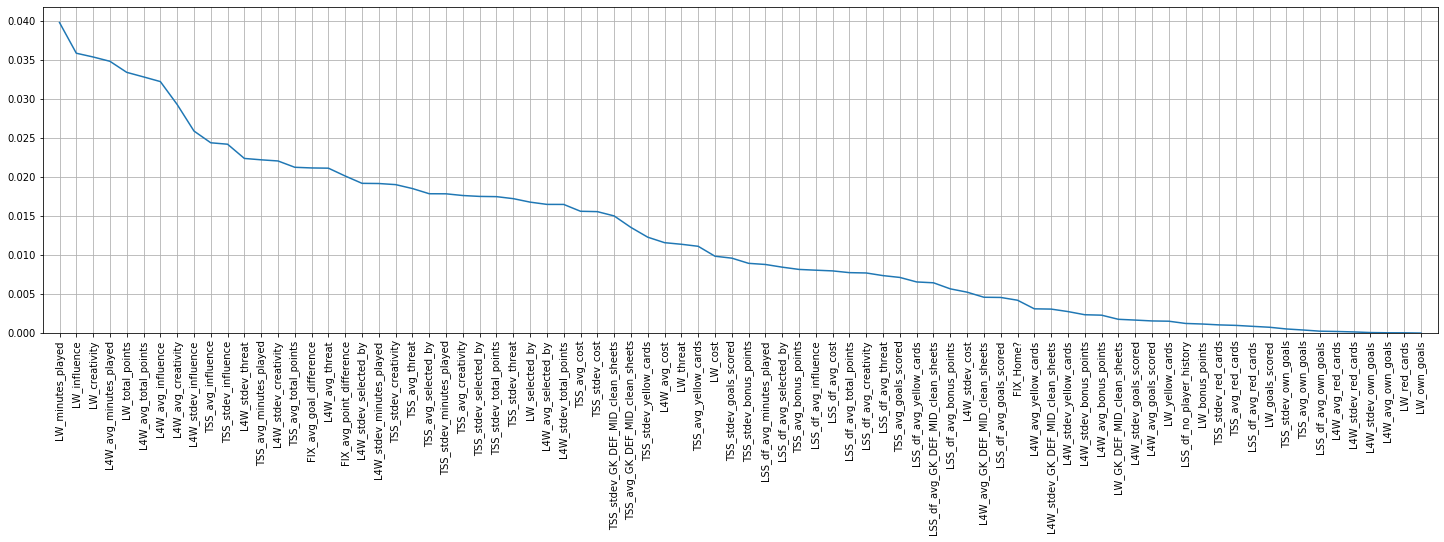

In [14]:
feature_ranking_MID_CAT = assess_feat_importance_CAT(historic_df_MID)
columns_MID_CAT = get_columns_to_use(feature_ranking_MID_CAT, rank_cutoff = 90, required_prefix=('FIX'))

In [15]:
start = dt.datetime.now()

X = historic_df_MID[columns_MID_CAT]
y = historic_df_MID['TARGET_total_points_BIN_QUAR']

# Create test and training dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Perform grid search to tune hyperparametres
gsc = GridSearchCV(estimator=RandomForestClassifier()
                  ,param_grid={'max_depth': range(3, 7),'n_estimators': (10, 50, 100, 1000)}
                  ,cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

print(best_params)

# Initialise regressor
RFClassifier = RandomForestClassifier(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"]
                                   ,random_state=False, verbose=False)

# RFClassifier = RandomForestClassifier(max_depth=4, n_estimators=100
#                                    ,random_state=False, verbose=False)

# # Perform K-Fold cross-validation
# scores = cross_val_score(RFRegressor, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

# # Fit data
# predictions = cross_val_predict(RFRegressor, X_train, y_train, cv=10)


# Fit
RFClassifier.fit(X_train,y_train)

prediction = RFClassifier.predict(X_test)

print("Time taken: ", dt.datetime.now() - start )

KeyboardInterrupt: 

In [ ]:
print(metrics.accuracy_score(y_test, prediction))

plot_confusion_matrix(RFClassifier, X_test, y_test)

## Linear regression

In [193]:
# Compute correlations
cor = historic_df_MID.corr()

#Correlation with output variable
cor_target = abs(cor["TARGET_total_points"])
cor_target.drop(index = [c for c in cor_target.index if str.startswith(c, ('TARGET'))], inplace = True)

cor_target.sort_values(ascending = False)

relevant_features = cor_target[cor_target>0.4]
relevant_features

LW_minutes_played         0.445187
L4W_avg_total_points      0.440366
L4W_avg_minutes_played    0.450197
L4W_avg_creativity        0.408141
L4W_avg_influence         0.427217
L4W_avg_threat            0.410819
TSS_avg_total_points      0.468907
TSS_stdev_total_points    0.418618
TSS_avg_minutes_played    0.431957
TSS_avg_creativity        0.407434
TSS_avg_influence         0.449678
TSS_stdev_influence       0.426931
TSS_avg_threat            0.414008
TSS_stdev_threat          0.400120
Name: TARGET_total_points, dtype: float64

R^2:  0.2378070898018183


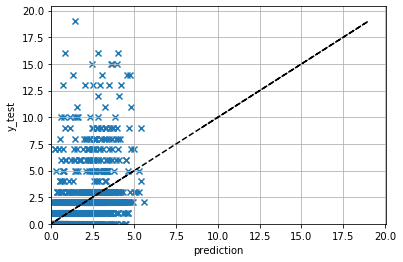

In [214]:
X = historic_df_MID[relevant_features.index.values].drop(columns = 'TSS_avg_total_points')
y = historic_df_MID['TARGET_total_points']

# Create test and training dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

regressor = LinearRegression() 
regressor.fit(X_train,y_train)
fit = regressor.predict(X_test) 

print('R^2: ',metrics.r2_score(y_test,fit))

plt.plot(y_test,y_test, linestyle = '--', c= 'k')
plt.scatter(fit,y_test , marker = 'x')
plt.grid()
plt.xlim(left = 0)
plt.ylim(bottom = 0)
plt.ylabel('y_test')
plt.xlabel('prediction')

plt.show()


In [222]:
print("Underestimating ",np.mean(np.where(fit < y_test,1,0)), '%')

Underestimating  0.2529039070749736 %


## Artificial neural network

### Create training set and scale

In [26]:
X = historic_df_MID[[c for c in historic_df_MID.columns if str.startswith(c, ('FIX', 'LW', 'L4W', 'TSS', 'LSS'))]]
y = historic_df_MID['TARGET_total_points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

a, evaluate_set, c, d = train_test_split(historic_df_MID, y, test_size=0.33, random_state=42)

scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)
StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Tune hyperparameters

In [29]:
mlp = MLPRegressor()
param_list = {"hidden_layer_sizes": [np.repeat(100,1),np.repeat(100,2),np.repeat(100,3),np.repeat(100,4),np.repeat(100,5)]
             ,"max_iter":[500,1000,3000,5000] 
             ,"activation": ["identity", "logistic", "tanh", "relu"]}

gsc = RandomizedSearchCV(estimator=mlp, param_distributions=param_list, verbose = 100, n_iter = 50, n_jobs = -1  )

grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Memmapping (shape=(3843, 82), dtype=float64) to new file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (shape=(769,), dtype=int64).
Pickling array (shape=(4,), dtype=int64).
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pick

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   36.7s
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (shape=(769,), dtype=int64).
Pickling array (shape=(2,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   36.9s
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3075,), dtype=int64).
Pickling array (sh

[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   51.3s
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3075,), dtype=int64).
Pickling array (shape=(768,), dtype=int64).
Pickling array (shape=(2,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   54.2s
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3075,), dtype=int64).
Pickling array (sh

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3075,), dtype=int64).
Pickling array (shape=(768,), dtype=int64).
Pickling array (shape=(5,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (sh

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.4min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (shape=(769,), dtype=int64).
Pickling array (shape=(3,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:  2.5min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (sh

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.0min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (shape=(769,), dtype=int64).
Pickling array (shape=(2,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:  3.1min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (sh

[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:  3.5min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (shape=(769,), dtype=int64).
Pickling array (shape=(4,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  3.5min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3075,), dtype=int64).
Pickling array (sh

[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  4.6min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3075,), dtype=int64).
Pickling array (shape=(768,), dtype=int64).
Pickling array (shape=(2,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:  4.7min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3075,), dtype=int64).
Pickling array (sh

[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:  5.5min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3075,), dtype=int64).
Pickling array (shape=(768,), dtype=int64).
Pickling array (shape=(3,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed:  5.5min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (sh

[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  6.1min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (shape=(769,), dtype=int64).
Pickling array (shape=(1,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  6.1min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (sh

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  6.7min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (shape=(769,), dtype=int64).
Pickling array (shape=(2,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.8min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (sh

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  7.2min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (shape=(769,), dtype=int64).
Pickling array (shape=(3,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:  7.3min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3075,), dtype=int64).
Pickling array (sh

[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  8.0min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3075,), dtype=int64).
Pickling array (shape=(768,), dtype=int64).
Pickling array (shape=(2,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed:  8.0min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3075,), dtype=int64).
Pickling array (sh

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  8.5min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3075,), dtype=int64).
Pickling array (shape=(768,), dtype=int64).
Pickling array (shape=(5,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:  8.5min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (sh

[Parallel(n_jobs=-1)]: Done 221 tasks      | elapsed:  9.1min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (shape=(769,), dtype=int64).
Pickling array (shape=(3,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:  9.1min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (sh

[Parallel(n_jobs=-1)]: Done 237 tasks      | elapsed:  9.7min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (shape=(769,), dtype=int64).
Pickling array (shape=(1,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  9.7min
Memmapping (shape=(3843, 82), dtype=float64) to old file /var/folders/x0/h9zbtpk5131g7yx68t8c3j9w0000gn/T/joblib_memmapping_folder_58105_9995083310/58105-112400308432-e619b04dadce4f028b2c1ab58938fc33.pkl
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3843,), dtype=float64).
Pickling array (shape=(3843,), dtype=int64).
Pickling array (shape=(3074,), dtype=int64).
Pickling array (sh

In [33]:
best_params

{'max_iter': 1000,
 'hidden_layer_sizes': array([100, 100, 100, 100]),
 'activation': 'identity'}

### Execute

R2:  0.21877107666719497


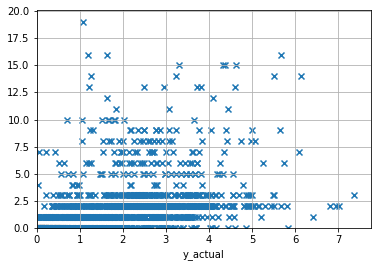

In [27]:
mlp = MLPRegressor(max_iter = 1000
                  ,hidden_layer_sizes = (100, 100, 100, 100)
                  ,activation = 'identity')


mlp.fit(X_train,y_train)
fit = mlp.predict(X_test)

plot_results(y_test,fit)

In [30]:
evaluate_set.insert(1,'prediction',fit)

In [31]:
evaluate_set

,PLAYER_id,prediction,PLAYER_name,PLAYER_Team,PLAYER_position,PLAYER_GW,PLAYER_Fixture_date,PLAYER_Opponent_id,PLAYER_Opponent,FORECAST,...,LSS_df_avg_influence,LSS_df_avg_threat,LSS_df_avg_GK_DEF_MID_clean_sheets,LSS_df_avg_selected_by,LSS_df_avg_cost,LSS_df_no_player_history,TARGET_minutes,TARGET_total_points,TARGET_total_points_BIN_EVEN,TARGET_total_points_BIN_QUAR
1647,101,1.498035,Ashley_Westwood_101,Burnley,3,18,2019-12-21,3,Bournemouth,0,...,16.394737,6.657895,0.184211,1.331667e+05,45.342105,0.0,90.0,5.0,3.0,3.0
16064,176,2.084840,Wilfred_Ndidi_176,Leicester,3,12,2019-11-09,1,Arsenal,0,...,19.105263,9.105263,0.236842,4.781895e+04,49.131579,0.0,90.0,3.0,2.0,3.0
13282,173,0.110256,Rachid_Ghezzal_173,Leicester,3,21,2020-01-01,13,Newcastle,0,...,3.889474,6.000000,0.026316,8.967132e+03,51.368421,0.0,0.0,0.0,1.0,0.0
13382,456,0.215796,Ravel_Morrison_456,Sheffield Utd,3,6,2019-09-21,8,Everton,0,...,8.534921,6.960317,0.146825,1.081968e+05,55.670635,1.0,0.0,0.0,1.0,0.0
7340,138,2.726887,James_McArthur_138,Crystal Palace,3,24,2020-01-21,16,Southampton,0,...,17.547368,12.815789,0.289474,1.275433e+05,48.157895,0.0,90.0,2.0,2.0,2.0
13328,214,4.550879,Raheem_Sterling_214,Man City,3,9,2019-10-19,7,Crystal Palace,0,...,27.894737,41.368421,0.447368,8.050246e+05,113.289474,0.0,90.0,5.0,3.0,3.0
4921,576,0.588326,Emile_Smith Rowe_576,Arsenal,3,21,2020-01-01,12,Man Utd,0,...,8.534921,6.960317,0.146825,1.081968e+05,55.670635,1.0,0.0,0.0,1.0,0.0
2194,152,1.561978,Bernard_Anício Caldeira Duarte_152,Everton,3,8,2019-10-05,5,Burnley,0,...,9.631579,9.921053,0.342105,1.399687e+04,59.105263,0.0,0.0,0.0,1.0,0.0
681,193,3.080596,Alex_Oxlade-Chamberlain_193,Liverpool,3,29,2020-03-07,3,Bournemouth,0,...,0.268421,0.500000,0.000000,2.305737e+03,64.131579,0.0,83.0,2.0,2.0,2.0
5106,346,1.249301,Erik_Lamela_346,Spurs,3,12,2019-11-09,15,Sheffield Utd,0,...,6.942105,11.605263,0.105263,3.099784e+04,61.894737,0.0,0.0,0.0,1.0,0.0


In [35]:
evaluation = evaluate_set.groupby('PLAYER_name')[['prediction','TARGET_total_points']].sum()
evaluation.head()

,prediction,TARGET_total_points
PLAYER_name,,
Aaron_Lennon_430,2.949582,1.0
Aaron_Mooy_516,13.536077,21.0
Abdoulaye_Doucouré_368,32.910936,28.0
Adam_Lallana_195,9.365847,12.0
Adama_Traoré_417,37.510589,52.0


In [36]:
evaluation.columns

Index(['prediction', 'TARGET_total_points'], dtype='object')

R2:  0.21877107666719497


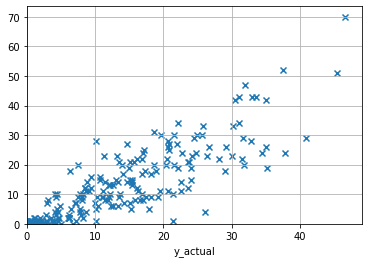

In [37]:
plot_results(evaluation['TARGET_total_points'],evaluation['prediction'])

In [39]:
evaluation['prediction_rank'] = evaluation['prediction'].rank()
evaluation['actual_rank'] = evaluation['TARGET_total_points'].rank()

In [43]:
evaluation.sort_values('prediction', ascending = False)

,prediction,TARGET_total_points,prediction_rank,actual_rank
PLAYER_name,,,,
Mohamed_Salah_191,46.591688,70.0,251.0,251.0
Kevin_De Bruyne_215,45.450752,51.0,250.0,249.0
Pierre-Emile_Højbjerg_325,40.965137,29.0,249.0,232.0
Mason_Mount_463,37.841659,24.0,248.0,216.0
Adama_Traoré_417,37.510589,52.0,247.0,250.0
Leander_Dendoncker_420,35.147884,19.0,246.0,190.5
Nicolas_Pépé_488,35.040649,26.0,245.0,222.5
Bamidele_Alli_344,35.023647,42.0,244.0,243.5
Wilfried_Zaha_133,34.423950,24.0,243.0,216.0


## KNN

## SVM

## LASSO regression

In [38]:
# Compute correlations
cor = historic_df_MID.corr()

#Correlation with output variable
cor_target = abs(cor["TARGET_total_points"])
cor_target.drop(index = [c for c in cor_target.index if str.startswith(c, ('TARGET'))], inplace = True)

cor_target.sort_values(ascending = False)

relevant_features = cor_target[cor_target>0.4]
relevant_features

LW_minutes_played         0.445187
L4W_avg_total_points      0.440366
L4W_avg_minutes_played    0.450197
L4W_avg_creativity        0.408141
L4W_avg_influence         0.427217
L4W_avg_threat            0.410819
TSS_avg_total_points      0.468907
TSS_stdev_total_points    0.418618
TSS_avg_minutes_played    0.431957
TSS_avg_creativity        0.407434
TSS_avg_influence         0.449678
TSS_stdev_influence       0.426931
TSS_avg_threat            0.414008
TSS_stdev_threat          0.400120
Name: TARGET_total_points, dtype: float64

R2:  0.23378075473391946


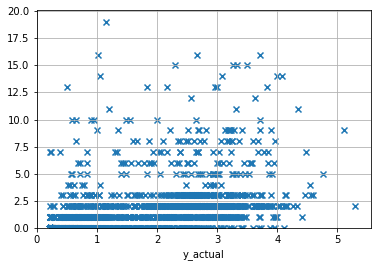

In [39]:
X = historic_df_MID[relevant_features.index.values].drop(columns = 'TSS_avg_total_points')
y = historic_df_MID['TARGET_total_points']

# Create test and training dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

regressor = Lasso() 
regressor.fit(X_train,y_train)
fit = regressor.predict(X_test) 

plot_results(y_test,fit)



## LightGBM